# Question A4

In this section, we will understand the utility of such a neural network in real world scenarios.

#### Please use the real record data named ‘record.wav’  as a test sample. Preprocess the data using the provided preprocessing script (data_preprocess.ipynb) and prepare the dataset.
Do a model prediction on the sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons.
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5,
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)



1. Firstly, we import relevant libraries.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

To reduce repeated code, place your
network (MLP defined in QA1)
torch datasets (CustomDataset defined in QA1)
loss function (loss_fn defined in QA1)
in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.


In [2]:
# YOUR CODE HERE
from common_utils import MLP_Custom, CustomDataset, EarlyStopper, train_loop, test_loop, split_dataset

2. Install and import shap

In [3]:
import shap

3. Read the csv data preprocessed from 'record.wav', using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [4]:
df = pd.read_csv("new_record.csv")  
size_row = df.shape[0]
size_column = df.shape[1]  

df

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,record.wav,[112.34714674],280,70.0,0.478361,0.111058,0.579547,0.091646,0.268037,0.01149,...,-4.068467,46.23243,-4.134901,53.040028,-0.942353,35.10554,-3.529712,54.78144,-3.722852,53.242016


 4.  Preprocess to obtain the test data, save the test data as numpy array.

In [5]:
from sklearn.preprocessing import StandardScaler

# Scale x_value of record.wav based on previous training data
def preprocess(X_train, df):
    """preprocess your dataset to obtain your test dataset, remember to remove the 'filename' as Q1
    """
    df["tempo"] = df["tempo"].apply(lambda x: float(x.replace('[', '').replace(']', '').strip()))
    df = df.drop(["filename"], axis=1)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(df)
    return X_test_scaled

df_full = pd.read_csv('simplified.csv')
df_full['label'] = df_full['filename'].str.split('_').str[-2]
df_full['label'].value_counts()
X_train, y_train, X_test, y_test = split_dataset(df_full, ["filename", "label"], 0.2, 0)

X_test_scaled_eg = preprocess(X_train, df)

In [6]:
# Getting training data and test data for training the model
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
df['label'].value_counts()
X_train, y_train, X_test, y_test = split_dataset(df, ["filename", "label"], 0.2, 0)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

5. Do a model prediction on the sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [7]:
# Training the Model Again
no_features = 77
no_labels = 1
optimal_no_hidden = (256, 256) #Obtained from part A_3
no_folds = 5

optimal_bs = 64 #Obtained from part A_2
patience = 3
lr = 0.001
epochs = 100

train_data = CustomDataset(X_train_scaled, y_train)
test_data = CustomDataset(X_test_scaled, y_test)

train_dataloader = DataLoader(train_data, batch_size=optimal_bs, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=optimal_bs, shuffle=True)

model = MLP_Custom(no_features, optimal_no_hidden, no_labels)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_fn = nn.BCELoss()
early_stopper = EarlyStopper(patience=3, min_delta=0)

tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
for t in range(epochs):
    train_loss, train_correct = train_loop(train_dataloader, model,loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)

    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)

    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

    if early_stopper.early_stop(test_loss):
        break


Epoch 1: Train_accuracy: 57.06%, Train_loss: 0.678929, Test_accuracy: 59.78%, Test_loss: 0.669850
Epoch 2: Train_accuracy: 60.94%, Train_loss: 0.654652, Test_accuracy: 61.40%, Test_loss: 0.651598
Epoch 3: Train_accuracy: 64.36%, Train_loss: 0.626704, Test_accuracy: 63.06%, Test_loss: 0.643277
Epoch 4: Train_accuracy: 66.79%, Train_loss: 0.605341, Test_accuracy: 63.93%, Test_loss: 0.641594
Epoch 5: Train_accuracy: 69.49%, Train_loss: 0.575910, Test_accuracy: 67.91%, Test_loss: 0.609848
Epoch 6: Train_accuracy: 71.32%, Train_loss: 0.553587, Test_accuracy: 67.00%, Test_loss: 0.601528
Epoch 7: Train_accuracy: 72.98%, Train_loss: 0.527027, Test_accuracy: 68.33%, Test_loss: 0.597425
Epoch 8: Train_accuracy: 74.78%, Train_loss: 0.504630, Test_accuracy: 69.61%, Test_loss: 0.583583
Epoch 9: Train_accuracy: 77.31%, Train_loss: 0.480625, Test_accuracy: 69.40%, Test_loss: 0.602210
Epoch 10: Train_accuracy: 77.78%, Train_loss: 0.460416, Test_accuracy: 71.89%, Test_loss: 0.557477
Epoch 11: Train_acc

In [8]:
#TODO: liat klo orng lain dpt final prediction yg sma 

# Doing prediction of trained model on X_test_scaled_eg
with torch.no_grad():
    pred = model(torch.tensor(X_test_scaled_eg, dtype=torch.float))
    
    #class 0 : neg, class 1: pos
    pred_label = 1 if pred.detach().numpy() >= 0.5 else 0
    pred_class = "pos" if pred_label == 1 else "neg"
    
    print(f"Final Prediction: {pred_class}, {pred_label}")

Final Prediction: pos, 1


6. Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5,
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)


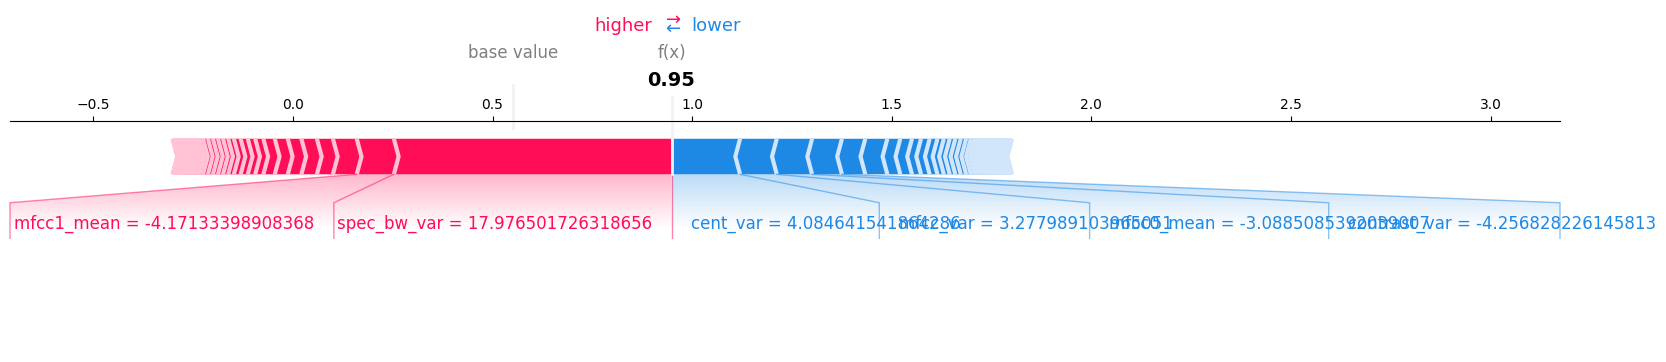

In [9]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
#TODO: liat hasil orng lain + cara jelasinnya gmna 

# Initialize the SHAP DeepExplainer.
training_tensor = torch.tensor(X_train_scaled, dtype=torch.float)
shap_explainer = shap.DeepExplainer(model, training_tensor)

X_test_tensor = torch.tensor(X_test_scaled_eg, dtype=torch.float32)
shap_values = shap_explainer.shap_values(X_test_tensor)

# Create the SHAP force plot for the isolated test sample
shap.initjs()
col_names = list(X_train.columns)
force_plot = shap.force_plot(
    shap_explainer.expected_value[0], 
    np.squeeze(shap_values[0]),  
    features=X_test_scaled_eg[0],  
    feature_names=col_names,  
    matplotlib=True  
)   

# Force Plot Analysis of Feature Importance

The **Force Plot** illustrates how the output value relates to the baseline, highlighting the impact of various features on the prediction. Below are the key findings regarding the most significant features based on the magnitude of their **SHAP Values**:

## Significant Features

- **spec_bw_var**: 
  - **Spectral Bandwidth Variance**
  - Elevates the prediction by approximately **17.98**.
  - This is the most substantial impact among all features.

- **cent_var**: 
  - **Spectral Centroid Variance**
  - Represents the "brightness" of a sound.
  - Decreases the prediction by around **4.08**.

- **mfcc1_mean**: 
  - The **first Mel-frequency cepstral coefficient**.
  - Lowers the prediction by about **4.17** compared to the baseline.

- **mfcc_var**: 
  - **Variance of Mel-frequency cepstral coefficients**.
  - Contributes to a decrease in the prediction by roughly **3.28**.

## Interpretation of Key Features

Focusing on the two features with the most significant influence on the prediction—one increasing and one decreasing—we can draw the following insights:

- The **Spectral Bandwidth Variance** may lead the model to favor audio with more dynamic timbre changes.
- The **Spectral Centroid Variance** suggests that rapidly fluctuating sound brightness is perceived negatively for this specific audio sample.

> **Note:** Since this is a **local feature importance plot**, its insights apply only to this particular audio sample. The relevance of different features may differ on a **global scale**.
